# Machine Learning Engineer Nanodegree
## Capstone Project : DeepTesla
March 18th, 2017

## Definition
### Project Overview

This project is based on Course [MIT 6.S094: Deep Learning for Self-Driving Cars](http://selfdrivingcars.mit.edu/deeptesl/)


### Problem Statement

This project is an end-to-end learning problem. The goal is to predict the steering wheel angel from Tesla dataset based on the video of the forward roadway.

### Datasets and Inputs

Databases with real-traffic video data captured and extracted 10 video clips of highway driving from Tesla:

- The wheel value was extracted from the in-vehicle CAN

- A window from each video frame is cropped/extracted and provide a CSV linking the window to a wheel value.

A snapshot of video frame:
<img src="./images/img/frame_1173.jpg" width = "320" height = "180" align=center />
    
The CSV data format:


|  ts_micro         | frame_index | wheel |
|:-----------------:|:-----------:|:-----:|
|  1464305394391807 | 0           | -0.5  |
| 1464305394425141  | 1           | -0.5  | 
| 1464305394458474  | 2           | -0.5  |


### Evaluation Metrics

This is a regression problem, MSE metrics is adopted here.

$$MSE = \frac{1}{N} \sum_{N}^{i=1}\sqrt{y_{p} - y}$$
where, $y_p$ is the predicted steering wheel angle, $y$ denotes the reference steering wheel angle, and the sample number is `N`. The lower MSE is preferred.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(42)

In [2]:
# Import local env
import params, preprocess

data_dir = params.data_dir
out_dir = params.out_dir
model_dir = params.model_dir
img_dir = os.path.abspath('./images/img/')

img_height = params.img_height
img_width = params.img_width
img_channels = params.img_channels
batch_size = params.batch_size
epochs = 10
num_classes = 1 # Regression problem

### Steering wheel angle

In [3]:
import glob
csv_files = glob.glob(os.path.join(data_dir, "*steering.csv"))
steering_csv = pd.concat((pd.read_csv(f) for f in csv_files))

In [4]:
steering_csv[-3:]

,frame,frame_index,ts_micro,wheel
2697,NaN,2697.0,1464305484291807,1.5
2698,NaN,2698.0,1464305484325141,1.5
2699,NaN,2699.0,1464305484358474,1.5


In [5]:
steering_csv.describe()

,frame,frame_index,ts_micro,wheel
count,5400.000000,21600.000000,2.700000e+04,27000.000000
mean,1616.166667,1349.500000,1.464374e+15,-0.338667
std,1120.991308,779.440853,1.382617e+11,4.438301
min,0.000000,0.000000,1.464304e+15,-18.000000
25%,674.750000,674.750000,1.464304e+15,-2.500000
50%,1349.500000,1349.500000,1.464305e+15,0.000000
75%,2549.250000,2024.250000,1.464306e+15,1.500000
max,3899.000000,2699.000000,1.464650e+15,15.000000


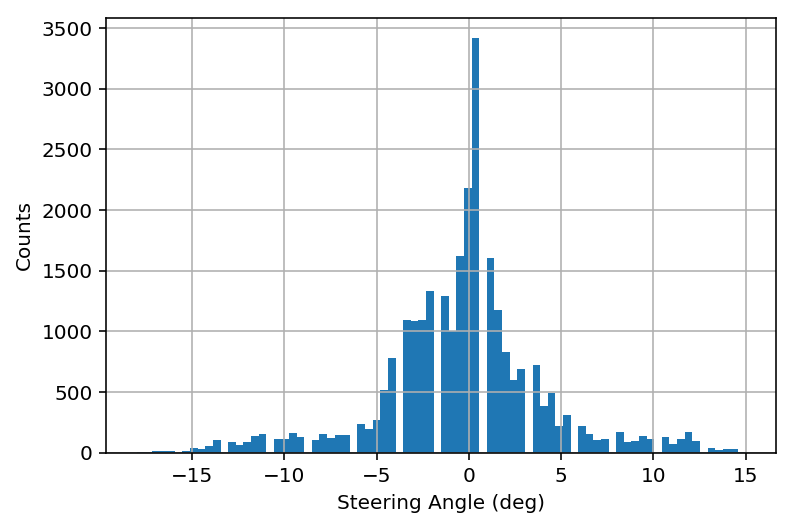

In [6]:
wheel = steering_csv['wheel']
plt.figure
plt.hist(wheel,80);
plt.xlabel('Steering Angle (deg)')
plt.ylabel('Counts')
#plt.title('Histogram of Steering Angle')
plt.grid(True)
plt.savefig(img_dir + "/Hist.png")

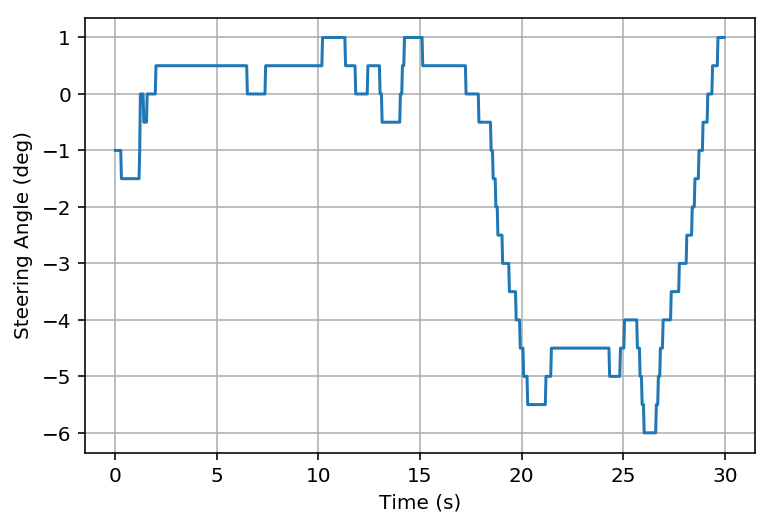

In [8]:
plt.figure;
plt.plot(np.arange( 0, 30, 1/30),wheel[:900]);
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle (deg)')
plt.grid(True)
plt.savefig(img_dir + "/steering_angle.png")
plt.show()

### Video Info

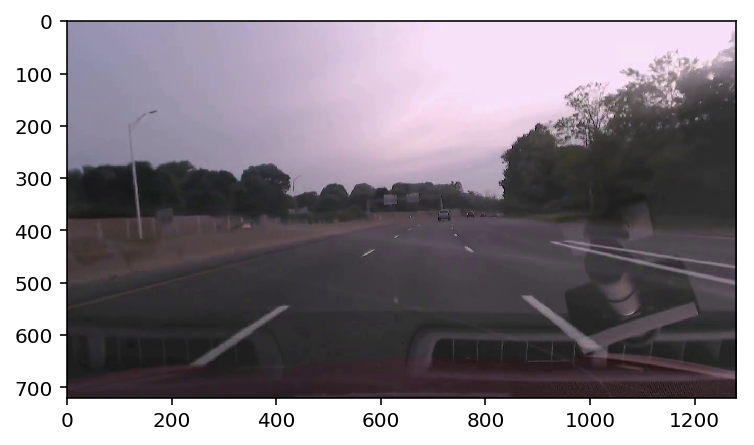

In [9]:
import matplotlib.image as mpimg
img=mpimg.imread("images/img/frame_1173.jpg")
imgplot = plt.imshow(img)

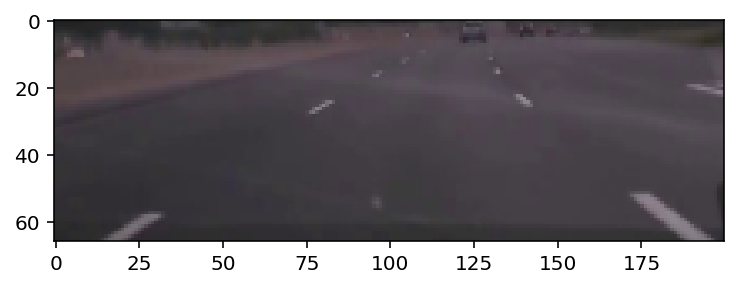

In [10]:
img = preprocess.preprocess(img)
imgplot = plt.imshow(img)

In [11]:
cap = cv2.VideoCapture("epochs/epoch03_front.mkv")
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = int(cap.get(cv2.CAP_PROP_FPS))

print (length,width,height,fps)

2702 1280 720 30


The frame count of video is large than csv 2 frame counts

- Merge all frames together with corresponding steering wheel angle.
- Show one frame of the preprocessed data.

## Data Preprocessing 

### Train data

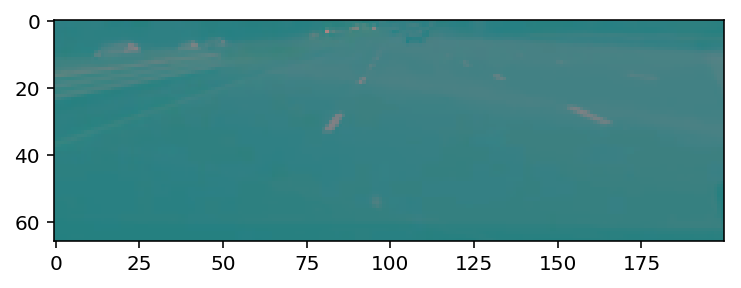

In [9]:
# Load epoches 1-9 as train data, argumented images with flip
imgs_data, wheels_data = preprocess.load_data('train', 'YUV', flip=True)
plt.imshow(imgs_data[1])

In [10]:
wheels_data.shape, imgs_data.shape

((24300, 1), (24300, 66, 200, 3))

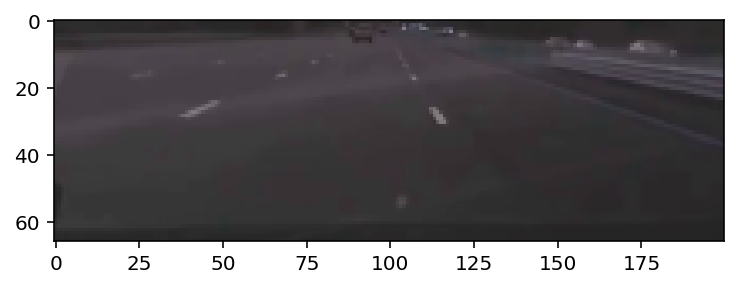

In [5]:
# RGB data
imgs_data_normal, wheels_data_normal = preprocess.load_data('train')
plt.imshow(imgs_data_normal[1])

In [6]:
wheels_data_normal.shape, imgs_data_normal.shape

((24301, 1), (24301,))

### Test data

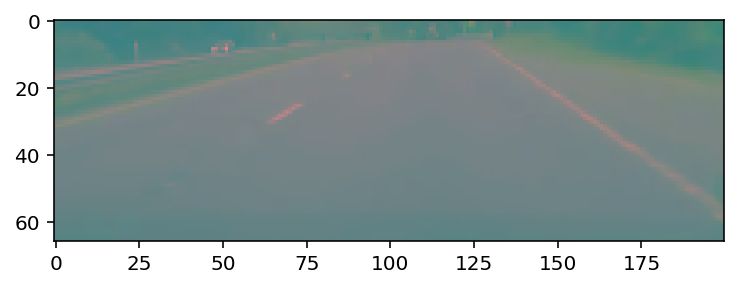

In [7]:
# Test data without flip
imgs_test, wheels_test = preprocess.load_data('test', 'YUV')
plt.imshow(imgs_test[1])

In [8]:
imgs_test.shape, wheels_test.shape

((2700, 66, 200, 3), (2700, 1))

In [ ]:
# Save train data into a pickle file.
import pickle
pickle.dump(imgs_data, open('data_imgs_train.p', 'wb'))
pickle.dump(wheels_data, open('data_wheels_train.p', 'wb'))

pickle.dump(imgs_data_normal, open('data_imgs_normal_train.p', 'wb'))
pickle.dump(wheels_data_normal, open('data_wheels_normal_train.p', 'wb'))

# Save test data into a pickle file.
pickle.dump(imgs_test, open('data_imgs_test.p', 'wb'))
pickle.dump(wheels_test, open('data_wheels_test.p', 'wb'))

## Checkpoint

In [3]:
# Load data back from the pickle file.
import pickle
imgs_data = pickle.load(open('data_imgs_train.p', 'rb'))
wheels_data = pickle.load(open('data_wheels_train.p', 'rb'))
imgs_data_normal = pickle.load(open('data_imgs_normal_train.p', 'rb'))
wheels_data_normal = pickle.load(open('data_wheels_normal_train.p', 'rb'))

imgs_test = pickle.load(open('data_imgs_test.p', 'rb'))
wheels_test = pickle.load(open('data_wheels_test.p', 'rb'))

In [4]:
# Check the data dimension
print(imgs_data.shape, wheels_data.shape)
print(imgs_test.shape, wheels_test.shape)

(48600, 66, 200, 3) (48600, 1)
(2700, 66, 200, 3) (2700, 1)


In [8]:
def split_data_set(x, y, test_size, shuffle=False):
    '''Split into train and valid sets with shuffle or order'''
    if shuffle:
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=test_size, random_state=42)
    else:
        split_point = int(len(wheels_data) * (1-test_size))
        X_train, X_val = x[:split_point], x[split_point:]
        y_train, y_val = y[:split_point], y[split_point:]
    return X_train, X_val, y_train, y_val

In [11]:
# Split data into train and valid sets
X_train, X_val, y_train, y_val = split_data_set(imgs_data, wheels_data, test_size=0.2, shuffle=True)

X_train_normal, X_val_normal, y_train_normal, y_val_normal = split_data_set(imgs_data_normal, wheels_data_normal, 
                                                                            test_size=0.2, shuffle=True)

print(X_train.shape[0], 'train samples, ', X_val.shape[0], 'Valid samples')
print('X_train shape:', X_train.shape, '\nX_val shape:',X_val.shape)
print('y_train shape:',y_train.shape, '\ny_val shape:',y_val.shape)

38880 train samples,  9720 Valid samples
X_train shape: (38880, 66, 200, 3) 
X_val shape: (9720, 66, 200, 3)
y_train shape: (38880, 1) 
y_val shape: (9720, 1)


## Keras Implementation

In [12]:
import tensorflow as tf 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras import losses, regularizers
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


### Benchmark model

In [8]:
# NVIDIA model
def nvidia_model(img_height, img_width, img_channels):
    '''The nvidia_model.
    Input: img_height, img_width, img_channels'''
    model = Sequential()
    # Normalization
    model.add(Lambda(lambda x: x/255., 
                     input_shape=(img_height, img_width, img_channels)))
    # Cov layers
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    activation='relu'))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    activation='relu'))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2,2), padding='valid',
                    activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                    activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                    activation='relu'))
    # Fullyconnected layer
    model.add(Flatten())
    model.add(Dense(1164,
                    activation='relu'))
    model.add(Dense(100,
                    activation='relu'))
    model.add(Dense(50,
                    activation='relu'))
    model.add(Dense(10,
                    activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='Adam')
    return model

In [9]:
# Train the model with ordered data 
base_model = nvidia_model(img_height, img_width, img_channels)
time_start = time.time()
# Fit the model
base_history = base_model.fit(imgs_data, wheels_data,
                              epochs=epochs, 
                              batch_size=512,
                              validation_split=0.2)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= base_model.evaluate(imgs_test, wheels_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/10
38880/38880 [==============================] - 24s - loss: 21.2453 - val_loss: 16.6425

dict_keys(['val_loss', 'loss'])


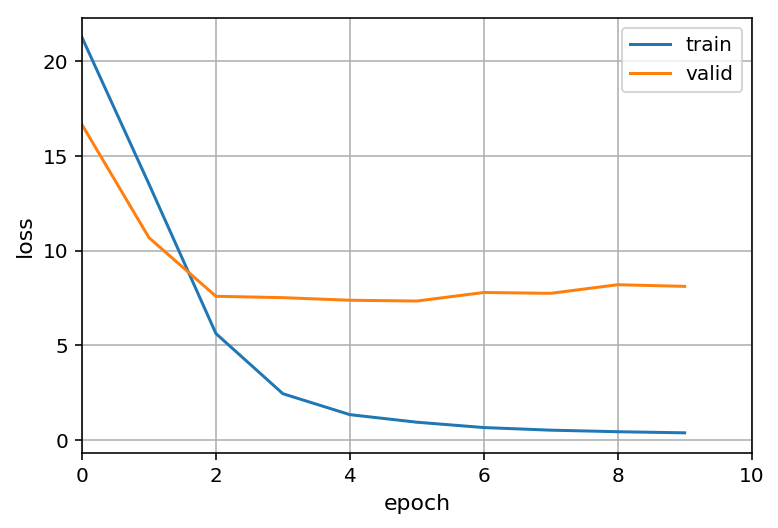

In [10]:
# list all data in history
print(base_history.history.keys())
# summarize history for loss
plt.plot(base_history.history['loss'])
plt.plot(base_history.history['val_loss'])

# plt.title('model loss')
plt.ylabel('loss', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend(['train', 'valid'], loc='best')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.savefig(img_dir + "/base_loss.png", dpi=300)
plt.show()

In [19]:
# Train the model with shuffled data
base_model = nvidia_model(img_height, img_width, img_channels)
time_start = time.time()
# Fit the model
base_shuffle_history = base_model.fit(X_train, y_train,
                                          validation_data=(X_val, y_val),
                                          epochs=10,
                                          batch_size=512,
                                          shuffle=True)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= base_model.evaluate(imgs_test, wheels_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/10
38880/38880 [==============================] - 22s - loss: 21.0327 - val_loss: 20.6318

In [13]:
# Train the model with ordered data and RGB images
base_model = nvidia_model(img_height, img_width, img_channels)
time_start = time.time()
# Fit the model
base_RGB_history = base_model.fit(imgs_data_normal, wheels_data_normal,
                                  epochs=10, 
                                  batch_size=512,
                                  validation_split=0.2)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= base_model.evaluate(imgs_test, wheels_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/10
38880/38880 [==============================] - 22s - loss: 19.9017 - val_loss: 13.7676

In [20]:
# Train the model with shuffled data and RGB images
base_model = nvidia_model(img_height, img_width, img_channels)
time_start = time.time()
# Fit the model
base_RGB_shuffle_history = base_model.fit(X_train_normal, y_train_normal,
                                          validation_data=(X_val_normal, y_val_normal),
                                          epochs=10,
                                          batch_size=512,
                                          shuffle=True)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= base_model.evaluate(imgs_test, wheels_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/10
38880/38880 [==============================] - 22s - loss: 21.0570 - val_loss: 21.4782

dict_keys(['val_loss', 'loss'])


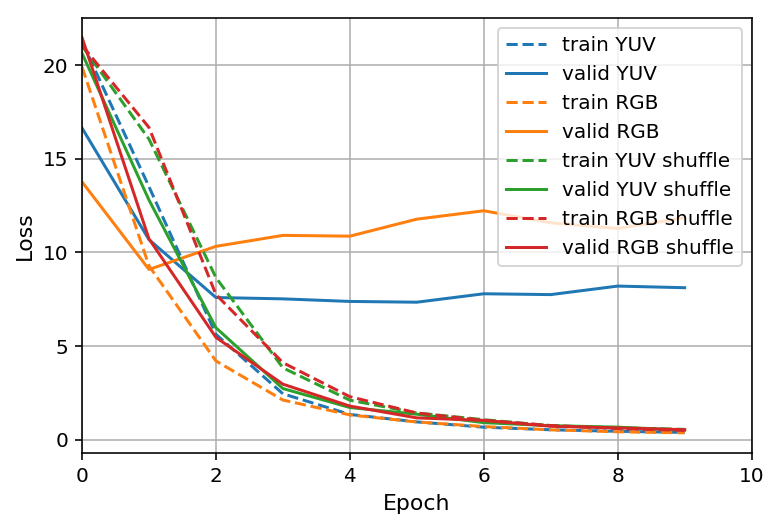

In [21]:
# list all data in history
print(base_history.history.keys())
# summarize history for loss
plt.plot(base_history.history['loss'], 'C0--')
plt.plot(base_history.history['val_loss'], 'C0')

plt.plot(base_RGB_history.history['loss'], 'C1--')
plt.plot(base_RGB_history.history['val_loss'], 'C1')

plt.plot(base_shuffle_history.history['loss'], 'C2--')
plt.plot(base_shuffle_history.history['val_loss'], 'C2')

plt.plot(base_RGB_shuffle_history.history['loss'], 'C3--')
plt.plot(base_RGB_shuffle_history.history['val_loss'], 'C3')

# plt.title('model loss')
plt.ylabel('Loss', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['train YUV', 'valid YUV', 'train RGB', 'valid RGB', 
            'train YUV shuffle', 'valid YUV shuffle','train RGB shuffle', 'valid RGB shuffle'], loc='upper right')
plt.xlim((0,10))
plt.xticks(np.arange(0, 11, 2))
plt.grid()
plt.savefig(img_dir + "/base_loss_compare.png", dpi=300)
plt.show()

In [22]:
print(base_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_9 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1152)              0         
__________

## Implementation

In [13]:
from keras.models import load_model
# model and json save path
model_saved_path = os.path.join(params.model_dir, "model.h5")
json_saved_path = os.path.join(params.model_dir, "model.json")

# If the model exists, load model from h5:
read_model = False
if read_model:
    if os.path.isfile(model_saved_path):
        model = load_model(model_saved_path)

In [32]:
# NVIDIA model
def nvidia_model_v3(img_height, img_width, img_channels):
    '''The nvidia_model.
    Input: img_height, img_width, img_channels'''
    model = Sequential()
    # Normalization
    model.add(Lambda(lambda x: x/255., 
                     input_shape=(img_height, img_width, img_channels)))
    # Cov layers
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), padding='valid',
                     kernel_initializer='he_normal',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2,2), padding='valid',
                     kernel_initializer='he_normal',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2,2), padding='valid',
                     kernel_initializer='he_normal',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                     kernel_initializer='he_normal',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                     kernel_initializer='he_normal',
                     activation='relu'))
    model.add(BatchNormalization())
    # Fullyconnected layer
    model.add(Flatten())
    model.add(Dense(1164,
                    kernel_initializer='he_normal',
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100,
                    kernel_initializer='he_normal',
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50,
                    kernel_initializer='he_normal',
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10,
                    kernel_initializer='he_normal',
                    activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='Adam')
    return model

In [33]:
# Train the model with ordered data
model = nvidia_model_v3(img_height, img_width, img_channels)
time_start = time.time()
# Fit the model
v3_history = model.fit(imgs_data, wheels_data,
                        epochs=epochs, 
                        batch_size=512, 
                        validation_split=0.2)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= model.evaluate(imgs_test, wheels_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/10
38880/38880 [==============================] - 27s - loss: 15.5253 - val_loss: 13.6059

In [34]:
# Train the model with shuffled data
model = nvidia_model_v3(img_height, img_width, img_channels)
time_start = time.time()
# Fit the model
v3_shuffle_history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs, 
                            batch_size=512,
                            shuffle=True)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

# Test the performance on test data
test_loss= model.evaluate(imgs_test, wheels_test, batch_size=512)
print('Test loss is:{}'.format(test_loss))

Train on 38880 samples, validate on 9720 samples
Epoch 1/10
38880/38880 [==============================] - 27s - loss: 15.7630 - val_loss: 20.6397

In [36]:
# list all data in history
print(v3_shuffle_history.history.keys())
# summarize history for loss
plt.plot(v3_history.history['loss'], 'C0--')
plt.plot(v3_history.history['val_loss'], 'C0')

plt.plot(v3_shuffle_history.history['loss'], 'C1--')
plt.plot(v3_shuffle_history.history['val_loss'], 'C1')
# plt.title('model loss')
plt.ylabel('Loss', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['train', 'valid', 'train shuffle', 'valid shuffle'], loc='best')
plt.xlim((0,20))
plt.xticks(np.arange(0, 21, 2))
plt.grid()
plt.savefig(img_dir + "/loss_compare.png", dpi=300)
plt.show()

NameError: name 'shuffle_history' is not defined

### Refinement
#### ELU

In [63]:
# Buld model with elu activation function based on the previous model
def build_model_elu(img_height, img_width, img_channels):
    '''The proposed model.
    Input: img_height, img_width, img_channels'''
    model = Sequential()
    # Normalization
    model.add(Lambda(lambda x: x/255., 
                     input_shape=(img_height, img_width, img_channels)))
    # Cov layers
    model.add(Conv2D(24, kernel_size=(3, 3), strides=(1,1), padding='valid',
                     kernel_initializer='TruncatedNormal',
                     activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(36, kernel_size=(3, 3), strides=(1,1), padding='valid',
                     kernel_initializer='TruncatedNormal',
                     activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(48, kernel_size=(3, 3), strides=(1,1), padding='valid',
                     kernel_initializer='TruncatedNormal',
                     activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                     kernel_initializer='TruncatedNormal',
                     activation='elu'))

    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1,1), padding='valid',
                     kernel_initializer='TruncatedNormal',
                     activation='elu'))
    # Fullyconnected layer
    model.add(Flatten())
    model.add(Dense(1164,
                    kernel_initializer='TruncatedNormal',
                    activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(100,
                    kernel_initializer='TruncatedNormal',
                    activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(50,
                    kernel_initializer='TruncatedNormal',
                    activation='elu'))
    model.add(Dropout(0.2))
    model.add(Dense(10,
                    kernel_initializer='TruncatedNormal',
                    activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='Adam')
    return model

In [64]:
# Train the model with ordered data
model = build_model_elu(img_height, img_width, img_channels)
time_start = time.time()
# Fit the model
elu_history = model.fit(imgs_data, wheels_data,
                    epochs=epochs*2, 
                    batch_size=512, 
                    validation_split=0.2)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

Train on 19440 samples, validate on 4860 samples
Epoch 1/20
19440/19440 [==============================] - 23s - loss: 24.9074 - val_loss: 14.7495

In [65]:
# Train the model with shuffled data
model = build_model_elu(img_height, img_width, img_channels)
time_start = time.time()
# Fit the model
elu_shuffle_history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs*2, 
                    batch_size=512)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

Train on 19440 samples, validate on 4860 samples
Epoch 1/20
19440/19440 [==============================] - 23s - loss: 23.7356 - val_loss: 21.5404

dict_keys(['val_loss', 'loss'])


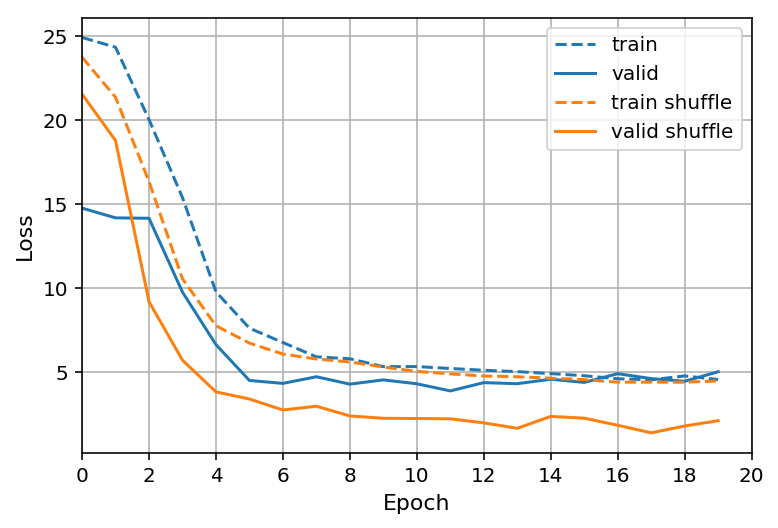

In [67]:
# list all data in history
print(shuffle_history.history.keys())
# summarize history for loss
plt.plot(elu_history.history['loss'], 'C0--')
plt.plot(elu_history.history['val_loss'], 'C0')

plt.plot(elu_shuffle_history.history['loss'], 'C1--')
plt.plot(elu_shuffle_history.history['val_loss'], 'C1')
# plt.title('model loss')
plt.ylabel('Loss', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['train', 'valid', 'train shuffle', 'valid shuffle'], loc='best')
plt.xlim((0,20))
plt.xticks(np.arange(0, 21, 2))
plt.grid()
plt.savefig(img_dir + "/elu_loss_compare.png", dpi=300)
plt.show()

#### Batch normalization and weight initial

In [160]:
# Add batch normalization, weight initializer, increase conv filter and use same padding.
def refined_model_v2(img_height, img_width, img_channels):
    '''The proposed model.
    Input: img_height, img_width, img_channels'''
    model = Sequential()
    # Normalization
    model.add(Lambda(lambda x: x/255., 
                     input_shape=(img_height, img_width, img_channels)))
    # Cov layers
    model.add(Conv2D(24, kernel_size=(3, 3), padding='same',
                     activation='elu',
                     kernel_initializer='he_normal',
                     name='re_conv1'))
    model.add(BatchNormalization(name='re_bn1'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='re_maxpool1'))
    
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same',
                    activation='elu',
                    kernel_initializer='he_normal',
                    name='re_conv2'))
    model.add(BatchNormalization(name='re_bn2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='re_maxpool2'))
    
    model.add(Conv2D(48, kernel_size=(3, 3), padding='same',
                    activation='elu',
                    kernel_initializer='he_normal',
                    name='re_conv3'))
    model.add(BatchNormalization(name='re_bn3'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='re_maxpool3'))
    
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same',
                    activation='elu',
                    kernel_initializer='he_normal',
                    name='re_conv4'))
    model.add(BatchNormalization(name='re_bn4'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='re_maxpool4'))
    
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same',
                    activation='elu',
                    kernel_initializer='he_normal',
                    name='re_conv5'))
    model.add(BatchNormalization(name='re_bn5'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='re_maxpool5'))
     
    # Fullyconnected layer
    model.add(Flatten())
    model.add(Dense(1164,
                   activation='elu',
                   kernel_initializer='he_normal',
                   name='re_den1'))
    model.add(Dropout(0.2))
    
    model.add(Dense(100,
                   activation='elu',
                   kernel_initializer='he_normal',
                   name='re_den2'))
    model.add(Dropout(0.2))
    
    model.add(Dense(50,
                   activation='elu',
                   kernel_initializer='he_normal',
                   name='re_den3'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10,
                   activation='elu',
                   kernel_initializer='he_normal',
                   name='re_den4'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))
    
    adam = keras.optimizers.Adam(lr= 0.002, decay=1e-7)
    model.compile(loss='mse', optimizer=adam)
    return model

In [161]:
final_model = refined_model_v2(img_height, img_width, img_channels)
print(final_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_54 (Lambda)           (None, 66, 200, 3)        0         
_________________________________________________________________
re_conv1 (Conv2D)            (None, 66, 200, 24)       672       
_________________________________________________________________
re_bn1 (BatchNormalization)  (None, 66, 200, 24)       96        
_________________________________________________________________
re_maxpool1 (MaxPooling2D)   (None, 33, 100, 24)       0         
_________________________________________________________________
re_conv2 (Conv2D)            (None, 33, 100, 32)       6944      
_________________________________________________________________
re_bn2 (BatchNormalization)  (None, 33, 100, 32)       128       
_________________________________________________________________
re_maxpool2 (MaxPooling2D)   (None, 16, 50, 32)        0         
__________

In [162]:
# Train the model with ordered data
final_model = refined_model_v2(img_height, img_width, img_channels)
time_start = time.time()
# Fit the model
final_history = final_model.fit(imgs_data, wheels_data,
                                epochs=epochs*2, 
                                batch_size=256, 
                                validation_split=0.2)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

Train on 19440 samples, validate on 4860 samples
Epoch 1/20
19440/19440 [==============================] - 40s - loss: 22.0121 - val_loss: 12.9051

In [ ]:
# Train the model with shuffled data
final_model_shuffle = refined_model_v2(img_height, img_width, img_channels)
time_start = time.time()
# Fit the model
final_shuffle_history = final_model_shuffle.fit(X_train, y_train,
                                                validation_data=(X_val, y_val),
                                                epochs=epochs*2, 
                                                batch_size=256,
                                                shuffle=True)

total_time = time.time() - time_start
print('Training time: {}'.format(total_time))

Train on 19440 samples, validate on 4860 samples
Epoch 1/20
19440/19440 [==============================] - 40s - loss: 18.2007 - val_loss: 24.0080

dict_keys(['val_loss', 'loss'])


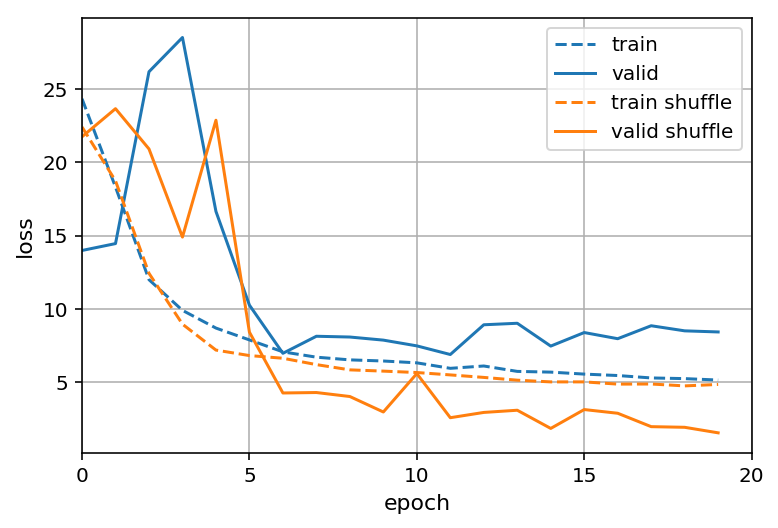

In [151]:
# list all data in history
print(final_history.history.keys())

# summarize history for loss
plt.plot(final_history.history['loss'], 'C0--')
plt.plot(final_history.history['val_loss'], 'C0')

plt.plot(final_shuffle_history.history['loss'], 'C1--')
plt.plot(final_shuffle_history.history['val_loss'], 'C1')

# plt.title('model loss')
plt.ylabel('loss', fontsize=11)
plt.xlabel('epoch', fontsize=11)
plt.legend(['train', 'valid', 'train shuffle', 'valid shuffle'], loc='best')
plt.xlim((0,20))
plt.xticks(np.arange(0, 21, 5))
plt.grid()
plt.savefig(img_dir + "/re_loss_compare.png", dpi=300)
plt.show()

In [137]:
# model and json save path
model_saved_path = os.path.join(params.model_dir, "model.h5")
json_saved_path = os.path.join(params.model_dir, "model.json")

# save json
json_model = re_model.to_json()
with open(json_saved_path, "w") as json_file:
    json_file.write(json_model)
# save model
re_model.save(model_saved_path)

## Results

### Model Evaluation on epoch 10

In [156]:
# Final evaluation of the model
test_loss= final_model_shuffle.evaluate(imgs_test, wheels_test, batch_size=256, verbose=1)
print('Test loss is:{}'.format(test_loss))

2700/2700 [==============================] - 2s     
Test loss is:4.46194384738251


In [30]:
# Final evaluation of the model
test_loss= base_model.evaluate(imgs_test, wheels_test, batch_size=256, verbose=1)
print('Test loss is:{}'.format(test_loss))

2700/2700 [==============================] - 0s     
Test loss is:4.311401649051242


In [ ]:
machine_steering = model.predict(imgs_test, batch_size=128, verbose=0)

In [ ]:
def get_human_steering(epoch_id):
    epoch_dir = params.data_dir
    assert os.path.isdir(epoch_dir)
    steering_path = os.path.join(epoch_dir, 'epoch{:0>2}_steering.csv'.format(epoch_id))
    assert os.path.isfile(steering_path)
    
    rows = pd.read_csv(steering_path)
    human_steering = list(rows.wheel.values)
    return human_steering

In [ ]:
human_steering = get_human_steering(10)

In [ ]:
plt.figure
plt.plot(machine_steering)
plt.plot(human_steering)
plt.ylabel('Steering angle (deg)')
plt.xlabel('Frame counts')
plt.legend(['Machine steering', 'Human steering'], loc='upper right')
plt.xlim((0,2700))
#plt.xticks(np.arange(0, 21, 5))
plt.grid()
plt.savefig(img_dir + "/result.png")
plt.show()

In [ ]:
# Data type transfer
human_steering = np.array(human_steering)
human_steering = np.reshape(human_steering,(len(human_steering),1))

In [ ]:
angle_error = np.subtract(machine_steering, human_steering)

In [ ]:
plt.figure
plt.plot(angle_error)
plt.ylabel('Steering angle error(deg)')
plt.xlabel('Frame counts')
plt.xlim((0,2700))
plt.grid()
plt.savefig(img_dir + "/result_error.png")
plt.show()

In [ ]:
import pydot_ng as pydot
import graphviz
pydot.find_graphviz()

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='re_model.png')